In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [3]:
!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

# import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
from PIL import Image 
import numpy
from scipy.misc import toimage
import scipy.ndimage
import matplotlib.pyplot as plt

In [5]:
def dodge(front,back):
    result=front*255/(255-back) 
    result[result>255]=255
    result[back==255]=255
    return result.astype('uint8')

def grayscale(rgb):
    return numpy.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [7]:
from PIL import ImageEnhance
from PIL import ImageOps

def enhance_image(original_image):
    enhanced_image = ImageEnhance.Contrast(original_image).enhance(1.)
    enhanced_image = ImageEnhance.Sharpness(enhanced_image).enhance(4.0)
    enhanced_image = ImageEnhance.Color(enhanced_image).enhance(0.0)
    #enhanced_image = ImageOps.invert(enhanced_image)
    
    plt.subplot(121)
    plt.title('Original')
    plt.imshow(numpy.array(original_image))

    plt.subplot(122)
    plt.title('Enhanced')
    plt.imshow(numpy.array(enhanced_image))
    
    return enhanced_image

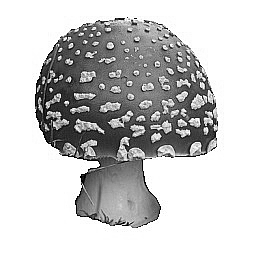

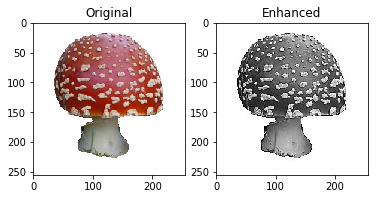

In [8]:
image = Image.open('train_photos/n12998815_9340.jpg')
enhance_image(image)

In [ ]:
# LOAD TRAINING PHOTOS
folder = 'train_photos/'
file_names = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Loading {0} photo training images...".format(len(file_names)))
train_photos = []
labels = []
for file_name in file_names:
    image = Image.open(folder + '/' + file_name)
    image = enhance_image(image)
    train_photos.append(numpy.array(image))
    labels.append(0)
print("Successfully loaded training photos!\n")
train_photos_ds = tf.data.Dataset.from_tensor_slices((train_photos, labels))

# LOAD TRAINING SKETCHES
folder = 'train_sketches/'
file_names = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Loading {0} sketch training images...".format(len(file_names)))
train_sketches = []
labels = []
for file_name in file_names:
    image = Image.open(folder + '/' + file_name)
    train_sketches.append(numpy.array(image))
    labels.append(1)
print("Successfully loaded training sketches!\n")
train_sketches_ds = tf.data.Dataset.from_tensor_slices((train_sketches, labels))

# LOAD TEST PHOTOS
folder = 'test_photos/'
file_names = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Loading {0} photo testing images...".format(len(file_names)))
test_photos = []
labels = []
for file_name in file_names:
    image = Image.open(folder + '/' + file_name)
    image = enhance_image(image)
    test_photos.append(numpy.array(image))
    labels.append(0)
print("Successfully loaded testing photos!\n")
test_photos_ds = tf.data.Dataset.from_tensor_slices((test_photos, labels))

# LOAD TEST SKETCHES
folder = 'test_sketches/'
file_names = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Loading {0} sketch testing images...".format(len(file_names)))
test_sketches = []
labels = []
for file_name in file_names:
    image = Image.open(folder + '/' + file_name)
    test_sketches.append(numpy.array(image))
    labels.append(1)
print("Successfully loaded testing sketches!\n")
test_sketches_ds = tf.data.Dataset.from_tensor_slices((test_sketches, labels))
    
# Show first image in the array to confirm the images were loaded.
# Image.fromarray(train_photos[0]).show()

Loading 89 photo training images...


/local/scratch/blacklleyt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Successfully loaded training photos!

Loading 518 sketch training images...


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [ ]:
def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)
    
    return image

In [ ]:
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [ ]:
def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [ ]:
train_photos_ds = train_photos_ds.map(
    preprocess_image_train,
    num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

train_sketches_ds = train_sketches_ds.map(
    preprocess_image_train,
    num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

test_photos_ds = test_photos_ds.map(
    preprocess_image_test,
    num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

test_sketches_ds = test_sketches_ds.map(
    preprocess_image_test,
    num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)


In [ ]:
sample_photo = next(iter(train_photos_ds))
sample_sketch = next(iter(train_sketches_ds))

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

In [ ]:
plt.subplot(121)
plt.title('Sketch')
plt.imshow(sample_sketch[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Sketch with random jitter')
plt.imshow(random_jitter(sample_sketch[0]) * 0.5 + 0.5)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
to_sketch = generator_g(sample_photo)
to_photo = generator_f(sample_sketch)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_photo, to_sketch, sample_sketch, to_photo]
title = ['Photo', 'To Sketch', 'Sketch', 'To Photo']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real sketch?')
plt.imshow(discriminator_y(sample_sketch)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real photo?')
plt.imshow(discriminator_x(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    
    return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 200

In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
    
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
    
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    print('Training epoch {} of {}.'.format(epoch + 1, EPOCHS))
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_photos_ds, train_sketches_ds)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    # Using a consistent image (sample_photo) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, sample_photo)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

In [41]:
for inp in test_photos_ds.take(5):
    generate_images(generator_g, inp)

ValueError: Incompatible type conversion requested to type 'int32' for variable of type 'float32'

In [40]:
for inp in test_sketches_ds.take(5):
    generate_images(generator_f, inp)

ValueError: Incompatible type conversion requested to type 'int32' for variable of type 'float32'

In [43]:
generate_images(generator_g, numpy.array(Image.open('train_photos/n12998815_21193.jpg')))

ValueError: Incompatible type conversion requested to type 'uint8' for variable of type 'float32'